Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [3]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [4]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [5]:
df.sample(10)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
3983,1,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,551,1,NaN,D4,"2 FIFTH AVENUE, 5E",NaN,...,0.0,0.0,0.0,0,0.0,1952.0,2,D4,848336,01/23/2019
14146,4,OTHER,02 TWO FAMILY DWELLINGS,1,9125,19,NaN,B2,75-04 GLENMORE AVENUE,NaN,...,2.0,0.0,2.0,"4,000",1564.0,1950.0,1,B2,0,03/12/2019
19119,4,OTHER,02 TWO FAMILY DWELLINGS,1,10181,37,NaN,B3,109-51 GUY R BREWER BLVD,NaN,...,2.0,0.0,2.0,"2,800",2326.0,1920.0,1,B3,0,04/04/2019
22479,4,OTHER,08 RENTALS - ELEVATOR APARTMENTS,2,1986,39,NaN,D9,42-12 108TH STREET,NaN,...,13.0,0.0,13.0,"2,500",12293.0,2008.0,2,D9,4050000,04/25/2019
12386,1,UPPER WEST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1242,62,NaN,D4,"710 WEST END AVENUE, 16E",NaN,...,0.0,0.0,0.0,0,0.0,1928.0,2,D4,790000,03/04/2019
21830,3,OTHER,02 TWO FAMILY DWELLINGS,1,4201,39,NaN,B1,1119 GLENMORE,NaN,...,2.0,0.0,2.0,"1,600",2480.0,1901.0,1,B1,0,04/19/2019
919,4,OTHER,02 TWO FAMILY DWELLINGS,1,2726,45,NaN,B2,60-27 59TH AVENUE,NaN,...,2.0,0.0,2.0,"2,000",1562.0,1940.0,1,B2,785000,01/07/2019
95,3,OTHER,07 RENTALS - WALKUP APARTMENTS,2B,821,54,NaN,C1,"259 55TH STREET, 8",8,...,8.0,0.0,8.0,"3,506",8160.0,1931.0,2,C1,3760000,01/02/2019
22265,3,OTHER,44 CONDO PARKING,4,323,1328,NaN,RP,"58 STRONG PLACE, P5",P5,...,0.0,1.0,1.0,0,0.0,1900.0,4,RP,1635000,04/24/2019
11574,4,OTHER,02 TWO FAMILY DWELLINGS,1,9417,21,NaN,B1,9532 116TH STREET,NaN,...,2.0,0.0,2.0,"2,668",2184.0,1965.0,1,B1,375000,02/27/2019


In [6]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [7]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

In [8]:
print(df.isnull().sum())
print(df.shape)

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64
(23040, 21)


In [9]:
# removing EASE-MENT and apartment number because of high nan values
df = df.drop(columns=['EASE-MENT', 'APARTMENT_NUMBER'])

In [10]:
df.shape

(23040, 19)

In [11]:
df = df.dropna()

In [12]:
df.shape

(22953, 19)

In [13]:
#Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' 
#and the sale price was more than 100 thousand and less than 2 million.

In [14]:
df_subset = df[(df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000) & (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')]

In [15]:
df_subset['SALE_PRICE'].min()

104000

In [16]:
df_subset['SALE_PRICE'].max()

1955000

In [17]:
train = df_subset[df_subset['SALE_DATE'] < pd.to_datetime('2019-04-01')]
test = df_subset[df_subset['SALE_DATE'] >= pd.to_datetime('2019-04-01')]

In [18]:
print(train.shape)
print(test.shape)

(2507, 19)
(644, 19)


In [19]:
# one-hot encoding
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2507,2507,2507,2507,2507,2507,2507,2507,2507
unique,5,6,1,2,13,2497,887,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,130-52 LEFFERTS BOULEVARD,"4,000",A1,2019-01-31 00:00:00
freq,1204,2382,2507,2476,919,2,234,919,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [20]:
import category_encoders as ce

In [21]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'LAND_SQUARE_FEET', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

In [22]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [23]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [24]:
X_train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,...,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [25]:
from sklearn.feature_selection import f_regression, SelectKBest
selector = SelectKBest(score_func=f_regression, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape

/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered

(2507, 30)

In [26]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features Selected:')
for name in selected_names:
  print(name)

print('')
print('Features Not Selected:')
for name in unselected_names:
  print(name)

Features Selected:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BLOCK
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_S0
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A4
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_A8
BUILDING_CLASS_AT_TIME_OF_SALE_S0

Features Not Selected:
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_P

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [28]:
for k in range(1, len(X_train.columns)+1):
    
    print(f'{k} features')
              
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
              
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mae: ${mae:,.0f} \n')          

/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered

1 features
Test Mae: $183,641 

2 features
Test Mae: $182,569 

3 features
Test Mae: $182,569 

4 features
Test Mae: $173,706 

5 features
Test Mae: $174,556 

6 features
Test Mae: $172,843 

7 features
Test Mae: $173,412 

8 features
Test Mae: $173,241 

9 features
Test Mae: $168,668 

10 features
Test Mae: $169,452 

11 features
Test Mae: $169,006 

12 features
Test Mae: $161,221 

13 features
Test Mae: $162,578 

14 features
Test Mae: $161,733 

15 features
Test Mae: $161,735 

16 features
Test Mae: $161,548 

17 features
Test Mae: $161,548 

18 features
Test Mae: $161,308 

19 features
Test Mae: $161,308 

20 features
Test Mae: $159,303 

21 features
Test Mae: $159,371 

22 features
Test Mae: $159,371 

23 features
Test Mae: $159,371 

24 features
Test Mae: $159,371 

25 features


/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered

Test Mae: $159,107 

26 features
Test Mae: $158,990 

27 features
Test Mae: $158,924 

28 features
Test Mae: $158,882 

29 features
Test Mae: $159,683 

30 features
Test Mae: $159,734 

31 features
Test Mae: $159,734 

32 features
Test Mae: $159,311 

33 features
Test Mae: $159,289 

34 features
Test Mae: $159,292 

35 features
Test Mae: $158,951 

36 features
Test Mae: $158,951 

37 features
Test Mae: $159,749 

38 features
Test Mae: $159,207 

39 features
Test Mae: $159,256 

40 features
Test Mae: $159,270 

41 features
Test Mae: $159,602 

42 features
Test Mae: $159,561 

43 features
Test Mae: $159,557 

44 features
Test Mae: $159,557 

45 features
Test Mae: $159,556 

46 features
Test Mae: $159,560 

47 features
Test Mae: $159,553 



/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/jordancarlisle/opt/anaconda3/envs/unit2/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered

In [29]:
# Featuring scaling for fit_tranform method on train set and test set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=150)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [31]:
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

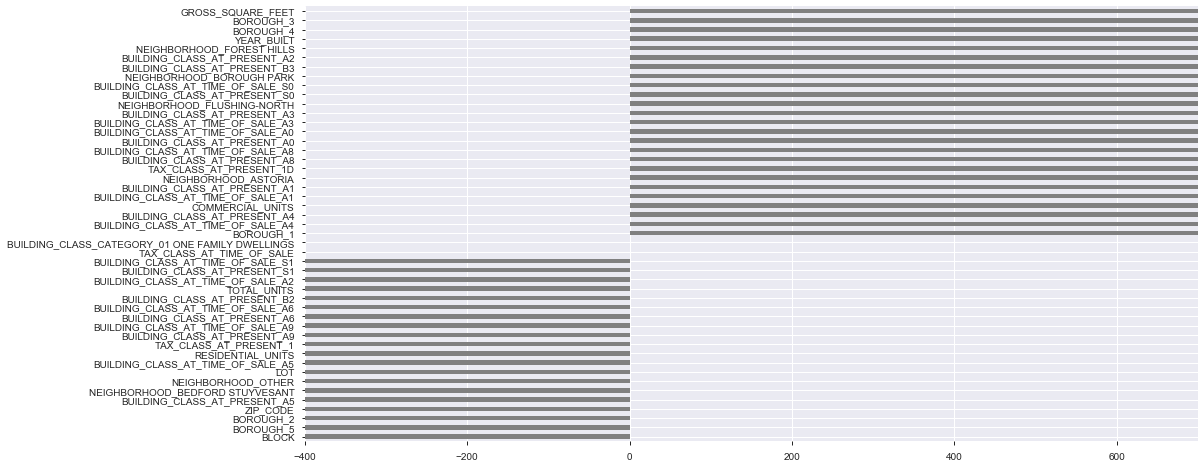

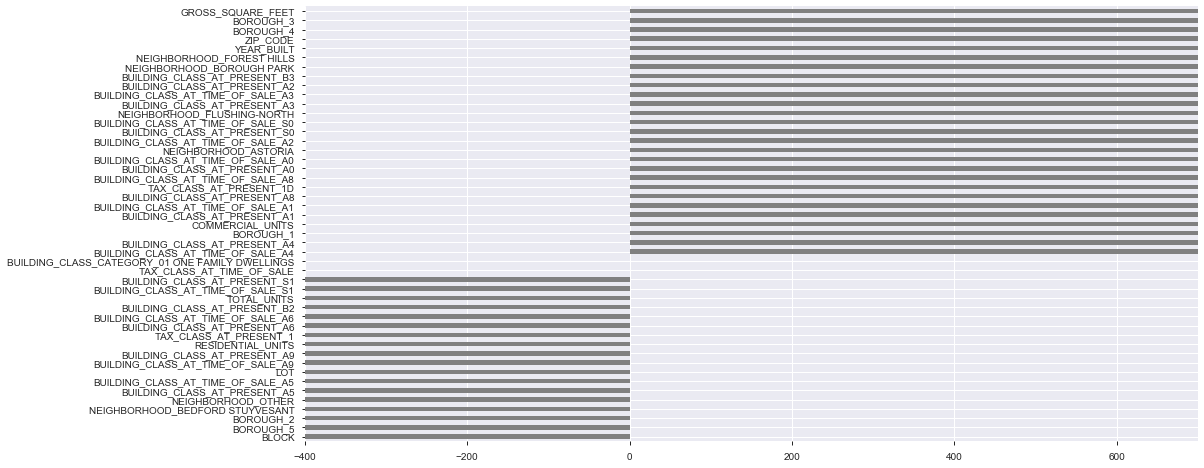

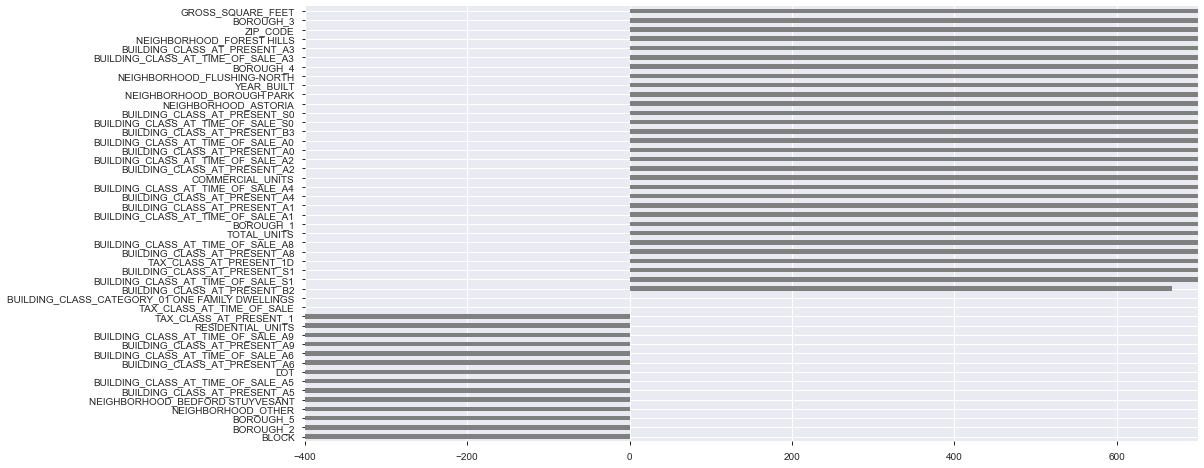

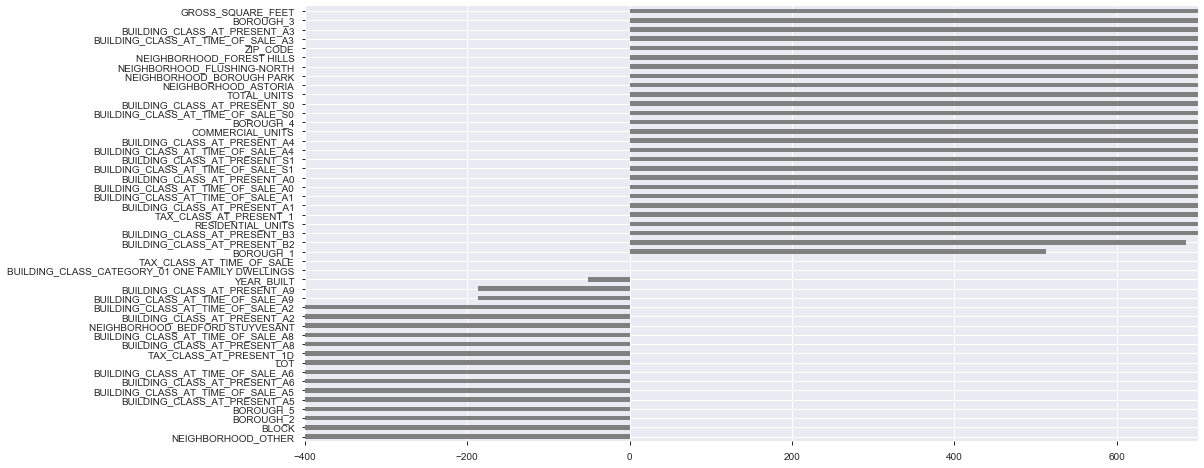

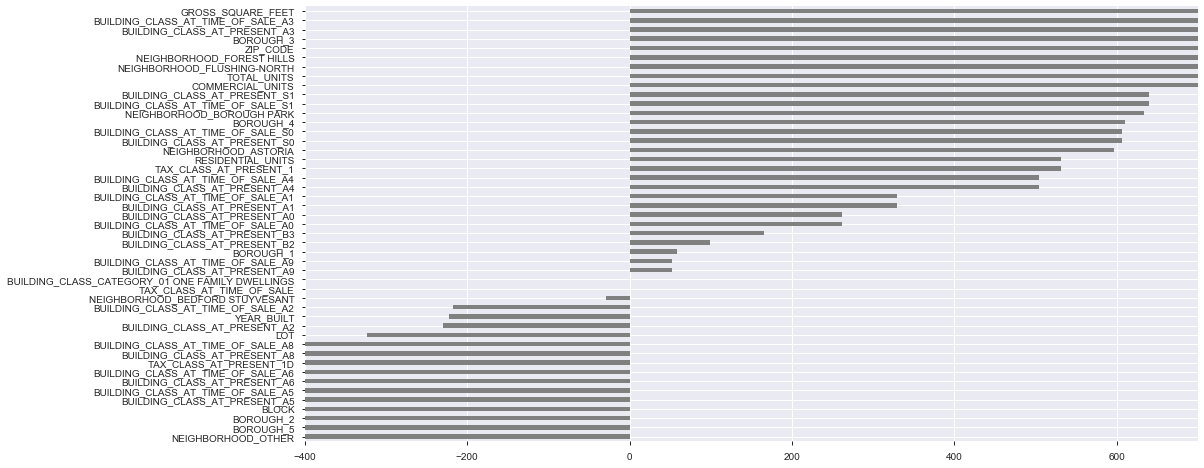

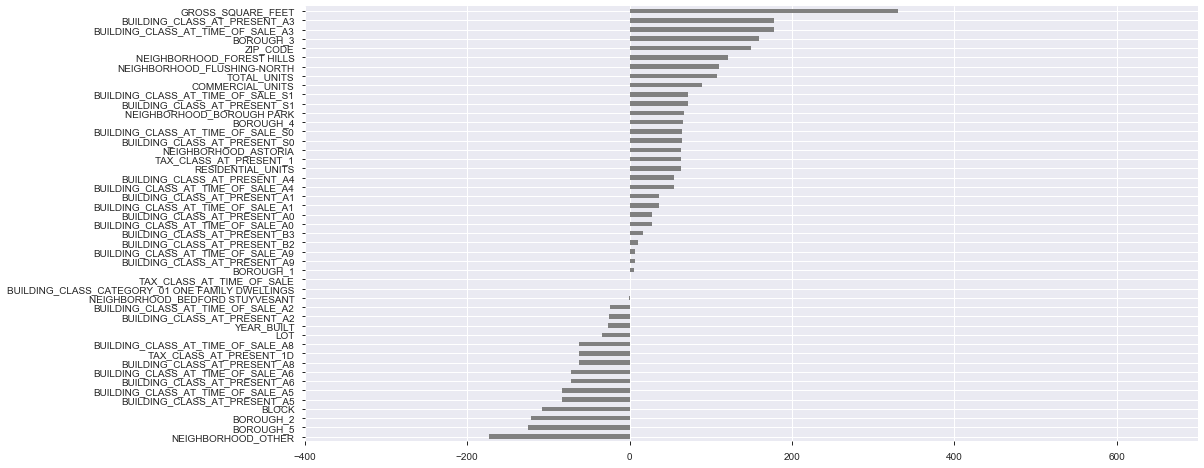

In [32]:
for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:    
    #scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # fit ridge regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # get test error
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()